In [58]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm

In [280]:
g = 30
lam = 5
is_connected = np.random.rand(g,g) < .25
is_connected = np.tril(is_connected, k=-1)
is_connected = is_connected + np.transpose(is_connected)
k = np.multiply(is_connected,np.random.rand(g,g))
K = np.multiply(is_connected,np.random.rand(g,g))
n0 = np.zeros(g) + 0.5

In [281]:
nt = simulate_dynamics(k,K,lam,n0,thresh = 0.001, cutoff = 500000, dt = 0.01)

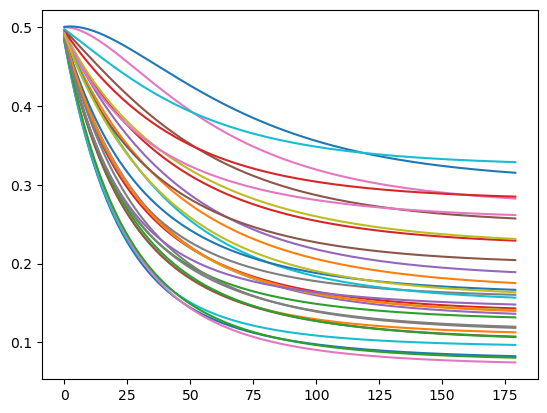

In [282]:
for i in range(nt.shape[0]):
    plt.plot(nt[i,:])

In [283]:
n0 = np.zeros(g) + 0.5
nt = simulate_dynamics(k,K,lam,n0,thresh = 0.001, cutoff = 500000, dt = 0.01)
n_f = nt[:,-1]
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)
w = np.real(w)
dlambda = np.sort(w)[-2]/np.sort(w)[-1]
lambdas = [dlambda]
IPR = calc_IPR(w,v)
for kk in tqdm(range(20000)):
    l = np.random.randint(len(np.nonzero(is_connected)[0]))
    i, j = np.nonzero(is_connected)[0][l],np.nonzero(is_connected)[1][l]
    k_new = np.array(k)
    K_new = np.array(K)
    K_new[i,j] = K_new[i,j] + (np.random.rand() - 0.5)*2/5
    k_new[i,j] = k_new[i,j] + (np.random.rand() - 0.5)*2/5
    if k_new[i,j] < 1 and K_new[i,j] < 1 and K_new[i,j] > 0 and k_new[i,j]> 0:
        n0 = np.zeros(g) + 0.5
        nt = simulate_dynamics(k_new,K_new,lam,n0)
        n_f = nt[:,-1]
        J = calc_J(k,K,n_f,lam)
        w, v = np.linalg.eig(J)
        w = np.real(w)
        dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
        IPR_new = calc_IPR(w,v)
        lambdas.append(dlambda_new)
        if (IPR_new < IPR or IPR_new < 2/g) and (dlambda_new > dlambda):
            k = k_new
            K = K_new
            dlambda = dlambda_new
            IPR = IPR_new


  9%|███▎                                  | 1730/20000 [00:58<10:12, 29.81it/s]


KeyboardInterrupt: 

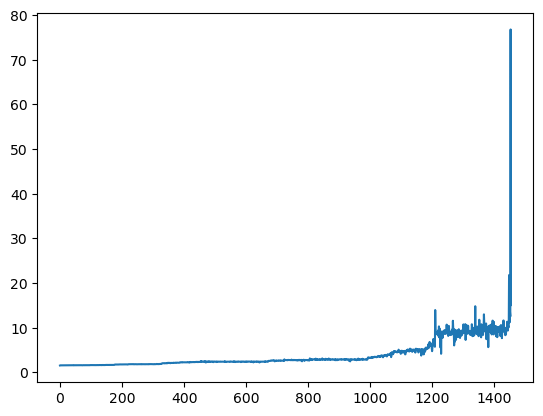

In [284]:
plt.plot(lambdas)

In [285]:
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)

In [353]:
from scipy.integrate import solve_ivp

In [359]:
def dndt(t,n):
    return calc_dndt(k,K,n,lam)

In [492]:
n_p_0 = n_f +.005*(np.random.random(len(n_f)) - 0.5)

In [507]:
t_span = [0, 200]  # Time span to solve the differential equation
rtol = 1e-6  # Relative tolerance for the solution
atol = 1e-9  # Absolute tolerance for the solution


In [508]:
sol = solve_ivp(dndt, t_span, n_p_0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

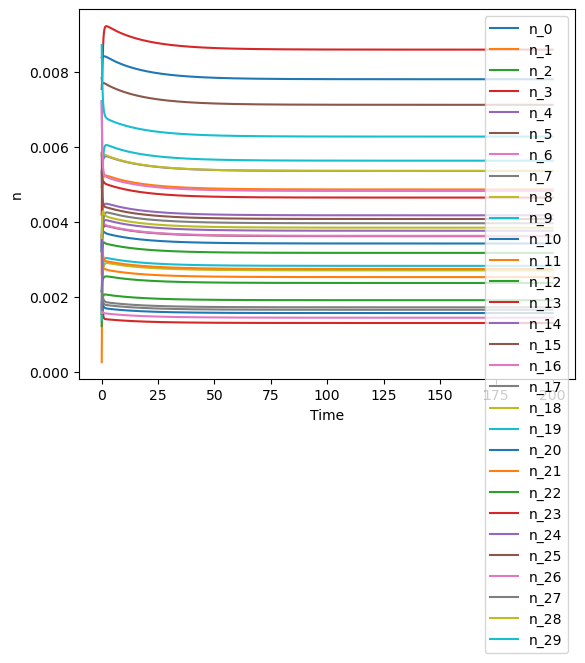

In [509]:
# Create an interpolating function for the solution
sol_fun = sol.sol

# Evaluate the solution at a large number of time points for plotting
t_eval = np.linspace(t_span[0], t_span[1], 1000)
n_eval = sol_fun(t_eval)

# Plot the trajectory of the solution
plt.figure()
for i in range(nt.shape[0]):
    plt.plot(t_eval, n_eval[i], label=f"n_{i}")
plt.xlabel("Time")
plt.ylabel("n")
plt.legend()
plt.show()

In [510]:
n_f = n_eval[:,-1]
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)


In [511]:
w[0]

(-0.05547271758273871+0j)

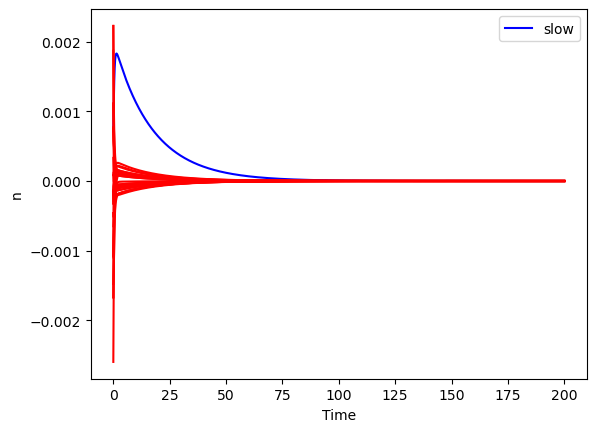

In [512]:
# Plot the trajectory of the solution
plt.figure()
for i in range(nt.shape[0]):
    v_plot = np.dot(n_eval.T,v[:,i])
    v_plot = (v_plot - v_plot[-1])
    if i == 0:
        plt.plot(t_eval, v_plot, label="slow",color = 'b')
    else:
        plt.plot(t_eval, v_plot,color = 'r')
plt.xlabel("Time")
plt.ylabel("n")
#plt.ylim([-0.001,0.001])
#plt.yscale('log')
plt.legend()
plt.show()

In [519]:
np.savetxt("KK.csv", K, delimiter=",")
np.savetxt("k.csv", k, delimiter=",")
